# Extreme Value Statistics of T cell clones with non-universal power law exponent

This code is an example on how to use the file 'EVS_functions.py' in order to fit the mixture EVS functions to the Emerson top clone data.

The notebook contains:
1. Definition of the integral
2. Fit to data

## Imports

- _numpy_ for math operations
- _matplotlib_ for graphic representations
- _pandas_ for operations with DataFrames
- _time_ to calculate the fitting time
- _scipy_ for integration
- _EVS_functions_ for the PDF and CDF functions from the mixture
- _multiprocessing_ to boost the fitting and multiple-point evaluations of the functions
- _lmfit_ for non-linear least squares fitting 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import time
from scipy.integrate import quad
from scipy.integrate import fixed_quad
from EVS_functions import g_m
from multiprocessing import Pool
from lmfit import Model, Parameters


## Loading data


To load the clone data, the user needs:

- top_1_clones_Emerson : file containing the data for the top clones of the whole Emerson cohort

The notebook and the 'top_1_clones_Emerson' file need to be in the same path. Otherwise, it is necessary to specify the path

Text(0, 0.5, 'Density distribution')

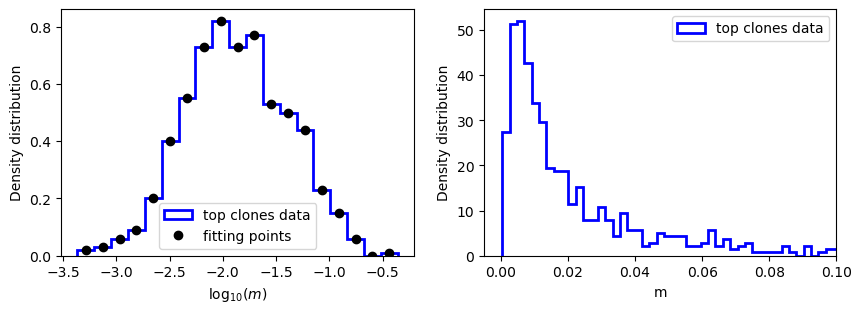

In [2]:
top_clones_file = 'top_1_clones_Emerson'  # change the name of file if necessary

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 3.2))

top_clones = pd.read_csv(top_clones_file)
top_clones['x'] = np.log10(top_clones['m'])

interval = np.linspace(top_clones['x'].min(), top_clones['x'].max(), 20)

peaks_r, edges_r, patches_r = ax1.hist(top_clones['x'], bins = interval,  # creating the density distribution
                                       density=True, fill=None, histtype='step', 
                                       color = 'blue', label = 'top clones data', lw=2) 
centers_r = np.array([(edges_r[i] + edges_r[i + 1]) / 2 for i in range(len(edges_r) - 1)])

ax1.plot(centers_r, peaks_r, 'o', color = 'black', label = 'fitting points')
ax1.legend()
ax1.set_xlabel(r'$\log_{10}(m)$')
ax1.set_ylabel('Density distribution')

ax2.hist(top_clones['m'], bins = 200, density = True, fill = None, histtype = 'step',
        color = 'blue', label = 'top clones data', lw = 2)
ax2.set_xlim([-0.005,0.1])
ax2.legend()
ax2.set_xlabel(r'm')
ax2.set_ylabel('Density distribution')

## 1. Definition of the integral

The function 'g_m' from 'EVS_functions' is the mixture PDF distribution

Multiprocessing makes the evaluation at multiple points faster

In [3]:
g_m

<function EVS_functions.g_m(x, z_avg, c, y)>

In [4]:
def g_m_multiprocess(x, z_avg, c, y):
    args = [(x_i, z_avg, c, y) for x_i in x]
    if __name__ == '__main__':
        with Pool(6) as p:  # 6 is the optimal number of cpu to use. My computer has 8. A good rule is n_cpu-2
            g_m_result = p.starmap(g_m, args)
    return g_m_result

## 2. Fit to data

### A. Fitting model and parameters

In [5]:
mixture_model = Model(g_m_multiprocess)  # fitting model

z0_avg = np.log10(0.5)  # initial conditions for the parameters
c0 = -2
y0 = -9

par = Parameters()  # definition of the parameters
par.add('z_avg', value = z0_avg, min = -1, max = 0) 
par.add('c',value = c0, min = -4, max = 0) 
par.add('y', value = y0, min = -11, max = -7)

peaks_fit = peaks_r  # data points for the fit
centers_fit = centers_r

### B. Fitting procedure

#### 1. Execution of the fit

In [6]:
time_ini = time.time() 

res = mixture_model.fit(peaks_fit, x = centers_fit, z_avg = par['z_avg'], c = par['c'], y = par['y'])  # fit

time_fin = time.time()
time_tot = (time_fin-time_ini)/60
print('Execution time: '+str(time_tot) + ' minutes')  # fitting time

Execution time: 322.143547018369 minutes


#### 2. Returned parameters and statistical analysis

In [9]:
z_opt = res.params['z_avg'].value  # optimal parameters
c_opt = res.params['c'].value
y_opt = res.params['y'].value

alpha_opt = 1+10**z_opt
sigma_opt = 10**c_opt
f_min_opt = 10**y_opt   

print('Optimal values:\n\t a0 = ' + str("%.2f"%alpha_opt) + '\n\t fm = ' + str("%.2e"%f_min_opt) 
     + '\n\t s² = ' + str("%.2f"%sigma_opt))

res  # statistical analysis of the fit

Optimal values:
	 a0 = 1.33
	 fm = 1.00e-07
	 s² = 0.04


#### 3. Representation

Text(0, 0.5, 'Density distribution')

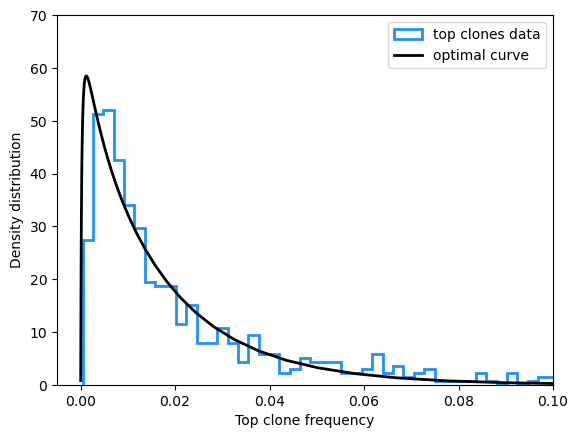

In [12]:
m_plot = np.logspace(-5, np.log10(top_clones['m'].max()), 75)  # creating the axis
x_plot = np.linspace(-5, top_clones['x'].max(), 75) 
PDF_plot = g_m_multiprocess(x_plot, z_opt, c_opt, y_opt)/(np.log(10)*m_plot)

plt.hist(top_clones['m'], bins = 200, density = True, fill = None, histtype = 'step',
        color = 'dodgerblue', label = 'top clones data', lw = 2)
plt.plot(m_plot, PDF_plot, label = r'optimal curve', color = 'black', lw = 2)

plt.xlim(-0.005, 0.1)
plt.ylim(0,70)
plt.legend(loc = 'upper right')
plt.xlabel('Top clone frequency')
plt.ylabel('Density distribution')